In [62]:
import numpy as np
from math import erfc, sqrt
import matplotlib.pyplot as plt
%matplotlib inline


In [63]:
# Transmitter
def BinarySource(n):
    return np.random.randint(0, 2, n)


In [64]:
def binarycode_to_signal(bitstream, step):
    T = 1
    A = 1
    pulse = np.ones(int(T/step))
    pulse = pulse*A
    signal = np.zeros(len(bitstream)*len(pulse))
    # Polar nonreturn to zero
    for i in range(len(bitstream)):
        if bitstream[i] == 1:
            # take the shape of pulse along the symbol's interval
            signal[i*len(pulse):(i+1)*len(pulse)] = 1*pulse
        else:
            signal[i*len(pulse):(i+1)*len(pulse)] = -1*pulse
    return signal


In [65]:
# Channel
# Add noise
def AWGN(n, sigma):
    return np.random.normal(0, sigma, n)


In [66]:
# Receiver

def receive_filter(signal_noise, filter_num, step):
    filter_num -= 1
    filters = [np.ones(int(1/step)), np.ones(1),
               np.sqrt(3)*np.arange(0, 1, step)]
    filter = filters[filter_num]
    filter = np.concatenate((filter, np.zeros(int(1/step)-len(filter))))
    signal_noise_filter = np.convolve(signal_noise, filter)
    if (filter_num == 0 or filter_num == 2):
        signal_noise_filter = signal_noise_filter*step
    return signal_noise_filter


In [67]:
def sampler(sampling_period, signal_noise_filtered, n=10):
    samples = np.zeros(n)
    for i in range(len(samples)):
        samples[i] = signal_noise_filtered[sampling_period-1+i*sampling_period]
    return samples


In [68]:
def Q(x):
    return 0.5 * erfc(x/sqrt(2))


In [69]:
def decision_maker(samples, lambd):
    return (samples > lambd)*1


In [70]:
# variance is the noise's variance and f is the filter's E_N. (1 or 2 or 3)
def compute_BER(variance, f):
    # generate the noise
    w_t = AWGN(len(g_t), variance)

    # add the Nise to the signal (3)
    s_t = g_t + w_t

    # apply the filter to the signal (4)
    y_t = receive_filter(s_t, f, step)

    # sample the filtered signal (5)
    sampling_period = int(T/step)
    # y_T has all samples
    y_iT = sampler(sampling_period, y_t, n)

    # decode the samples (6)
    # holds for all 3 cases.
    lambd = 0
    bitstream_output = decision_maker(y_iT, lambd)

    # compare the resulting bitstream with the original to compute the probability of error
    return np.sum(input_bitstream != bitstream_output)/len(input_bitstream)


In [71]:

n = 10
step = 0.05
t = np.arange(0, n, step)

sigma_noise = 0.1            # relates to the channel noise.
filter_num = 1
# generate the binary symbols
bitstream = BinarySource(n)
print("Bitstream: ", bitstream)


Bitstream:  [0 1 1 1 0 0 1 1 0 0]


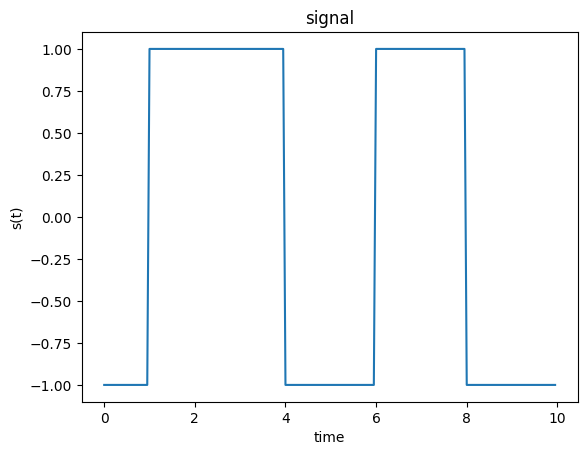

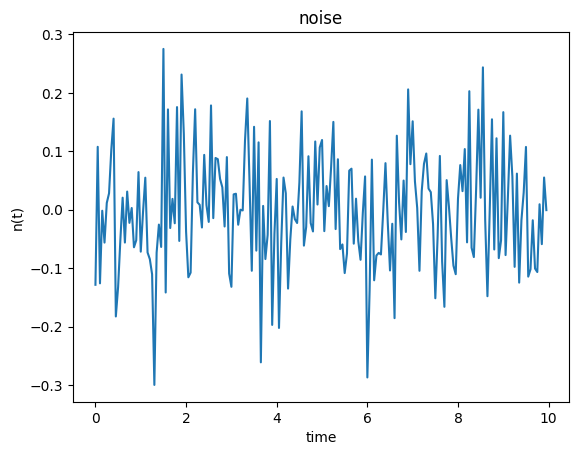

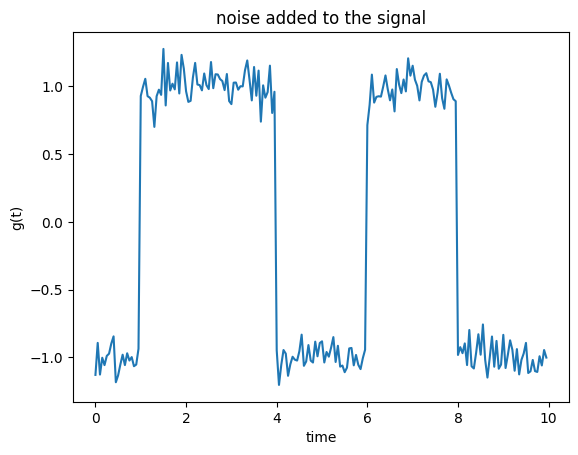

In [72]:
signal = binarycode_to_signal(bitstream, step)
plt.plot(t, signal)
plt.xlabel('time')
plt.ylabel('s(t)')
plt.title('signal')
plt.show()

# generate the noise
noise = AWGN(len(signal), sigma_noise)

plt.plot(t, noise)
plt.xlabel('time')
plt.ylabel('n(t)')
plt.title('noise')
plt.show()

# add the noise to the signal
signal_noise = signal+noise
plt.plot(t, signal_noise)
plt.xlabel('time')
plt.ylabel('g(t)')
plt.title('noise added to the signal')
plt.show()


Reconstructed Bitstram: [0 1 1 1 0 0 1 1 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


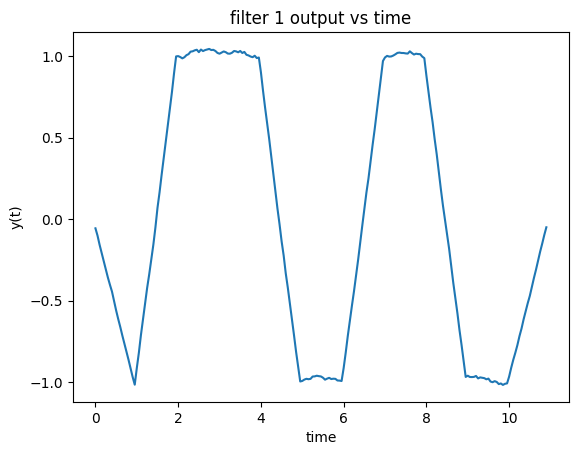

In [73]:

filter_num = 1
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


Reconstructed Bitstram: [0 1 1 1 0 0 1 1 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


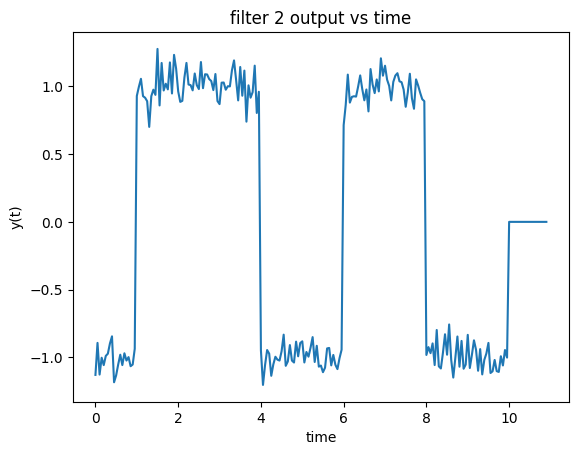

In [74]:

filter_num = 2
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


Reconstructed Bitstram: [0 1 1 1 0 0 1 1 0 0]
Total number of bits: 10
Received Wrong: 0
BER: 0.0


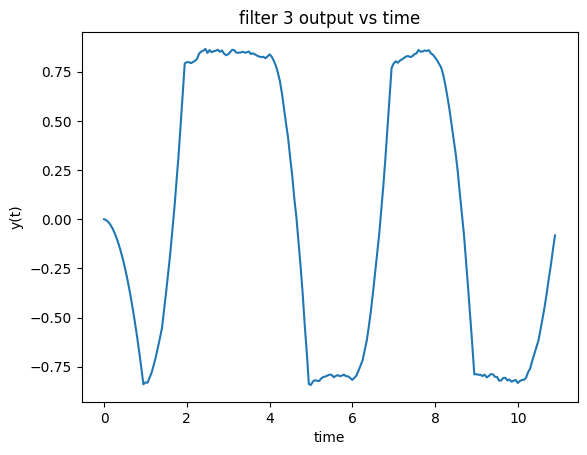

In [75]:

filter_num = 3
signal_noise_filter = receive_filter(signal_noise, filter_num, step)
plt.plot(np.arange(0, len(signal_noise_filter)*step, step), signal_noise_filter)
plt.xlabel('time')
plt.ylabel('y(t)')
plt.title('filter ' + str(filter_num) + ' output vs time')
plt.savefig('filter_' + str(filter_num) + '_output.jpg')

# sample the filtered signal
sampling_period = int(1/step)
samples = sampler(sampling_period, signal_noise_filter)
# decode the samples
reconstructed_bitstram = decision_maker(samples, 0)
print('Reconstructed Bitstram:', reconstructed_bitstram)
print("Total number of bits:", len(bitstream))
print("Received Wrong:", np.sum(bitstream != reconstructed_bitstram))
print("BER:", np.sum(bitstream != reconstructed_bitstram)/len(bitstream))


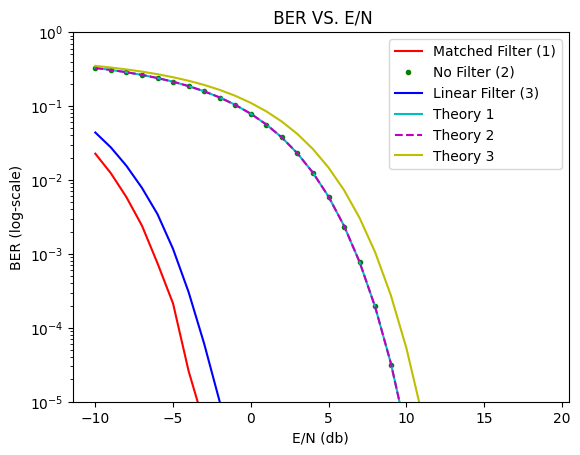

In [76]:
# bitstream length
n = 1000000
# 20 Samples per pulse of duration 1
step = 0.05
T = 1

# generate the binary symbols
input_bitstream = BinarySource(n)

# generate the binary signal
g_t = binarycode_to_signal(input_bitstream, step)

# plot BER VS. E/No for each filter
E_N = np.arange(-10, 20, 1)
N = 1/(10**(E_N/10))
# the corresponding range of sigma.
variance = np.sqrt(N/2)


# Filter 1:
filter1_BER, filter1_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter1_BER[i] = compute_BER(variance[i], 1)
    filter1_BER_th[i] = Q(1/variance[i])

# Filter 2:
filter2_BER, filter2_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter2_BER[i] = compute_BER(variance[i], 2)
    filter2_BER_th[i] = Q(1/variance[i])

# Filter 3:
filter3_BER, filter3_BER_th = np.zeros(len(variance)), np.zeros(len(variance))
for i in range(len(variance)):
    filter3_BER[i] = compute_BER(variance[i], 3)
    filter3_BER_th[i] = Q(np.sqrt(3)/2*1/variance[i])

plt.semilogy(E_N, filter1_BER, 'r')
plt.semilogy(E_N, filter2_BER, 'g.')
plt.semilogy(E_N, filter3_BER, 'b')
plt.semilogy(E_N, filter1_BER_th, 'c')
plt.semilogy(E_N, filter2_BER_th, 'm--')
plt.semilogy(E_N, filter3_BER_th, 'y')

plt.xlabel('E/N (db)')
plt.ylabel('BER (log-scale)')
plt.title(' BER VS. E/N')
plt.legend(['Matched Filter (1)', 'No Filter (2)',
           'Linear Filter (3)', 'Theory 1', 'Theory 2', 'Theory 3'])
plt.ylim([10/(n), 1])
plt.savefig('./BitErrorRate.png')
